In [1]:
# Importing libraries
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
# Set the directories for training, validation, and test data
main_dir ='/Users/anudavis/Desktop/Assignment'
train_dir = os.path.join(main_dir,'Dataset/OutputDataset/train')
validation_dir = os.path.join(main_dir,'Dataset/OutputDataset/val')
test_dir = os.path.join(main_dir,'Dataset/OutputDataset/test')

In [3]:
#Data Splitting to Train, Test and Validation Folders
import splitfolders
splitfolders.ratio(os.path.join(main_dir,'Dataset/OriginalDataset'),output=os.path.join(main_dir,'Dataset/OutputDataset'), seed='1337',ratio=(0.8,0.1,0.1))
#splitfolders.ratio('Dataset',output='Output', seed='1337',ratio=(0.8,0.1,0.1))

Copying files: 497 files [00:00, 923.91 files/s]


In [4]:
#Data Augmentation Step
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Data augmentation for the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.15)

# Only rescale the validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Set the batch size
batch_size = 16

# Get the training, validation, and test datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  
    batch_size=batch_size,
    class_mode='categorical',  # Change this to 'binary' if you only have two classes
    subset='training')

validation_generator = val_test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    subset='training')

Found 371 images belonging to 6 classes.
Found 51 images belonging to 6 classes.
Found 59 images belonging to 6 classes.


In [5]:
train_generator.class_indices

{'ApplePie': 0,
 'BagelSandwich': 1,
 'Bibimbop': 2,
 'Bread': 3,
 'FriedRice': 4,
 'Pork': 5}

In [6]:
original_classes = test_generator.classes

In [7]:
#Creating base model using pre-trained model (Fine tuning using Vgg)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import regularizers

fine_tune=2
input_shape=(150,150,3)

baseModel = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

if fine_tune > 0:
    for layer in baseModel.layers[:-fine_tune]:
        layer.trainable = False
else:
    for layer in baseModel.layers:
        layer.trainable = False

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel) 
# L2 regularization , kernel_regularizer=regularizers.l2(0.01)
#headModel = Dense(10, activation="relu")(headModel) 
headModel = Dropout(0.2)(headModel)
#headModel = Dropout(0.2)(headModel)
#lastlayer = Dense(6, activation="softmax")(headModel) # L2 regularization
lastlayer = Dense(6, activation="softmax")(headModel) # L2 regularization

# in lastlayer 6 is classes, Change the number here to match your number of classes

model = Model(inputs=baseModel.input, outputs=lastlayer)

#for layer in baseModel.layers:
 #   layer.trainable = False

opt = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


In [8]:
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping

plot_loss = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint = ModelCheckpoint(filepath=os.path.join(main_dir,'my_model.weights.best.hdf5'),
                                  save_best_only=True,
                                  verbose=1)


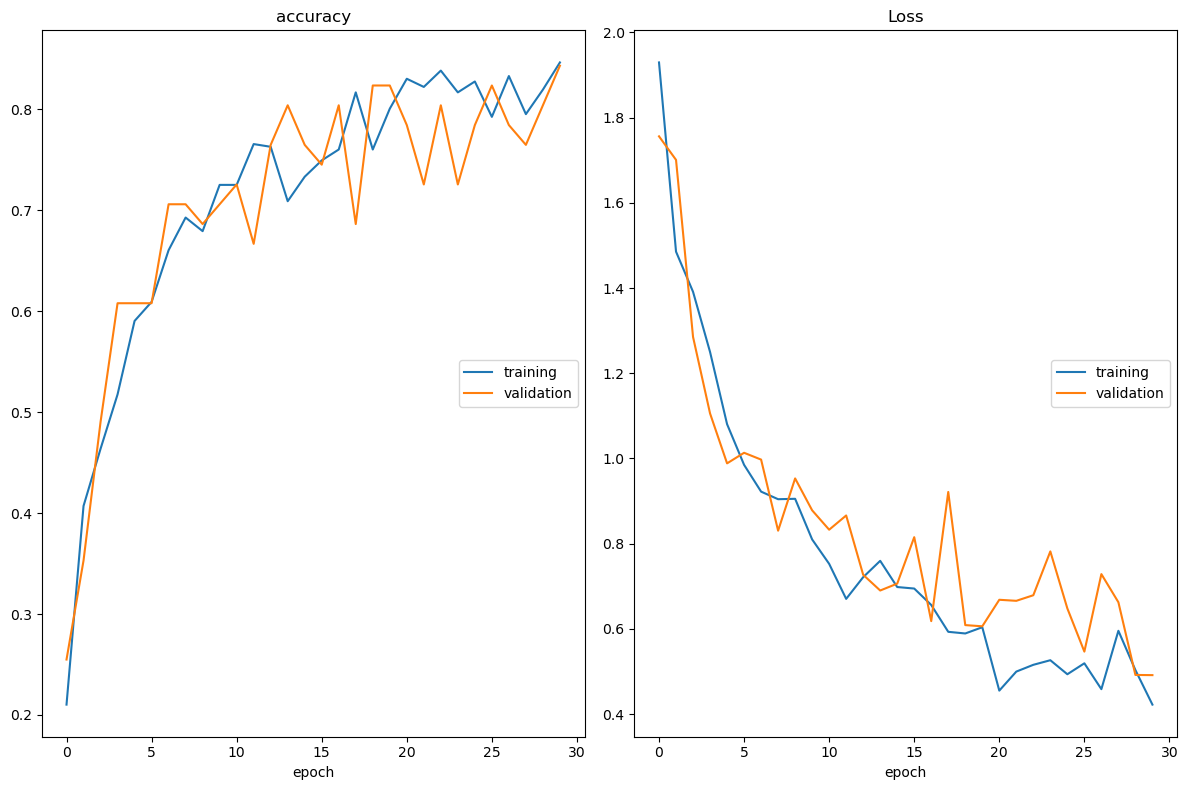

accuracy
	training         	 (min:    0.210, max:    0.846, cur:    0.846)
	validation       	 (min:    0.255, max:    0.843, cur:    0.843)
Loss
	training         	 (min:    0.422, max:    1.929, cur:    0.422)
	validation       	 (min:    0.492, max:    1.756, cur:    0.492)
24/24 [==============================] - 19s 797ms/step - loss: 0.4224 - accuracy: 0.8464 - val_loss: 0.4916 - val_accuracy: 0.8431


In [9]:
# EarlyStopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


model_history=model.fit(train_generator, steps_per_epoch=len(train_generator),
          validation_data=validation_generator, validation_steps=len(validation_generator),
          epochs=30, callbacks=[tl_checkpoint, early_stop, plot_loss],
                            verbose=1)

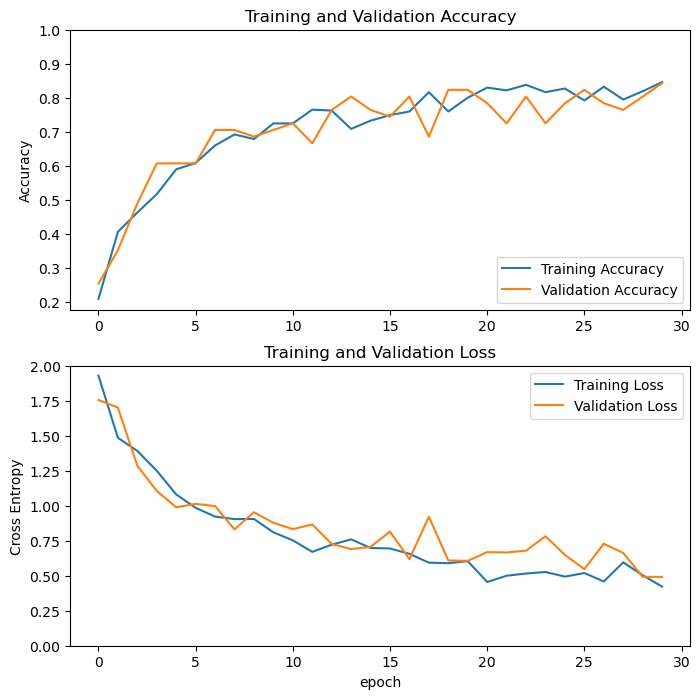

In [10]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

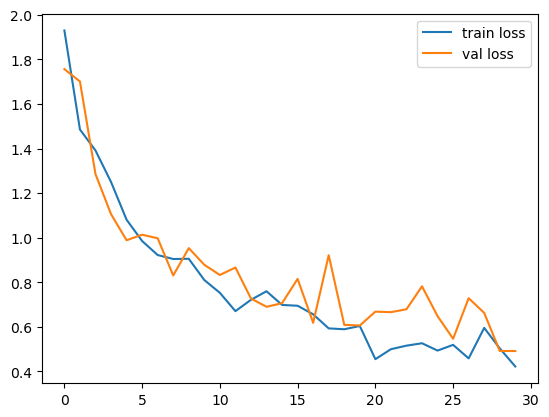

In [11]:
# loss
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('vgg-loss.png')
plt.show()

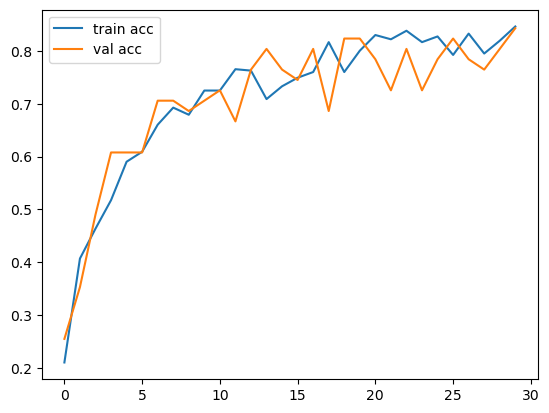

In [12]:
# accuracies
plt.plot(model_history.history['accuracy'], label='train acc')
plt.plot(model_history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('vgg-accuracy.png')
plt.show()

In [15]:
model.evaluate(test_generator,batch_size=1)

59/59 [==============================] - 3s 49ms/step - loss: 0.7428 - accuracy: 0.7627


[0.7428199052810669, 0.7627118825912476]

In [38]:
#Predictions
# Generate predictions
model.load_weights(os.path.join(main_dir,'my_model.weights.best.hdf5')) # initialize the best trained weights

vggModel_preds = model.predict(test_generator)
vggModel_pred_classes = np.argmax(vggModel_preds, axis=1)

59/59 [==============================] - 3s 51ms/step


In [39]:
# Let's take a look to see how many layers are in the base model
#print("Number of layers in the base model: ", len(baseModel.layers))

# Fine-tune from this layer onwards
#fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
#for layer in baseModel.layers[:fine_tune_at]:
 # layer.trainable = False

In [40]:

#model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])



In [41]:

#history_fine = model.fit(train_generator,
 #                        epochs=50,
  #                       initial_epoch=model_history.epoch[-1],
   #                      validation_data=validation_generator,callbacks=[tl_checkpoint_new, early_stop, plot_loss_new],
    #                        verbose=1)